# Initialize

In [4]:
# Data wrangling
import numpy as np
import pandas as pd
import string

# Data vizualization
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.cluster import kelbow_visualizer #, SilhouetteVisualizer, InterclusterDistance, , silhouette_visualizer

## -- Machine learning
import sklearn
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics.pairwise import cosine_similarity


In [5]:
df = pd.read_csv('data/data.csv', encoding='cp1252')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Understanding and Preparation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.drop(columns=['Description'], inplace=True)      # not useful here

## Data Cleaning

In [8]:
df.dropna(subset=['CustomerID'], inplace=True)      # Customer ID is a key information, we can't continue without it  
df['CustomerID'] = df['CustomerID'].astype(str)

In [9]:
df.info()       # no more missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Quantity     406829 non-null  int64         
 3   InvoiceDate  406829 non-null  datetime64[ns]
 4   UnitPrice    406829 non-null  float64       
 5   CustomerID   406829 non-null  object        
 6   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 24.8+ MB


In [10]:
print(df.duplicated().sum())
df[df.duplicated(keep=False)].head(10)

5227


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
494,536409,21866,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
521,536409,22900,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
527,536409,22866,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
548,536412,22327,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
555,536412,22327,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom


In [11]:
df.drop_duplicates(inplace=True) 

In [12]:
df.describe()[['Quantity', 'UnitPrice']]

,Quantity,UnitPrice
count,401602.000000,401602.000000
mean,12.182579,3.474064
std,250.283248,69.764209
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [13]:
df = df.query('Quantity > 0 & UnitPrice > 0')       # senseless values

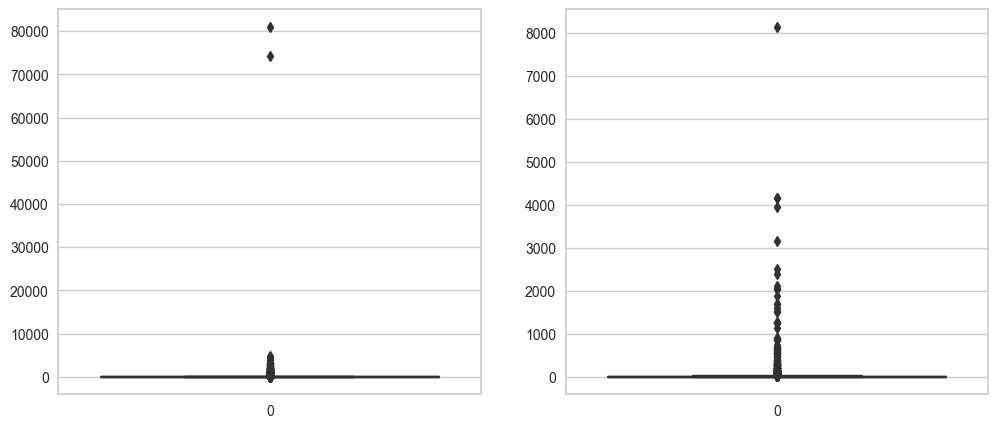

In [14]:
# looking for outliers
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(df['Quantity'])
plt.subplot(1,2,2)
sns.boxplot(df['UnitPrice'])
plt.show()

In [15]:
# Removing outliers
outQ = df.describe(percentiles=[.95])['Quantity']['95%']
outU = df.describe(percentiles=[.95])['UnitPrice']['95%']
df.query('Quantity <= @outQ & UnitPrice <= @outU', inplace=True)

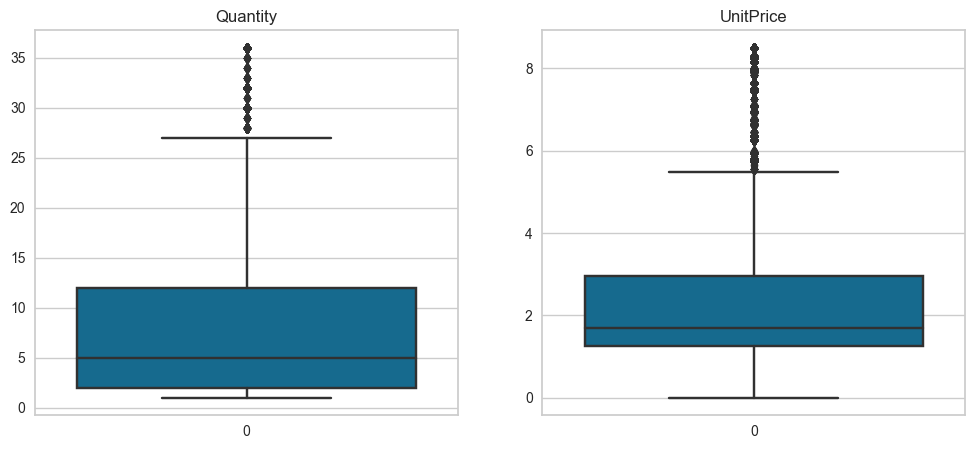

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(df['Quantity'])
plt.title('Quantity')
plt.subplot(1,2,2)
sns.boxplot(df['UnitPrice'])
plt.title('UnitPrice')
plt.show()

## Feature Engineering

In [17]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

### RFM

In [18]:
df_RFM = df.groupby('CustomerID').agg({
    'InvoiceDate': 'max',
    'Quantity': 'sum',
    'TotalPrice': 'mean'
     }
).reset_index().set_index('CustomerID').rename(columns={'InvoiceDate': 'R', 'Quantity': 'F', 'TotalPrice': 'M'}
)
df_RFM

,R,F,M
CustomerID,,,
12347.0,2011-12-07 15:52:00,2151,21.513966
12348.0,2011-04-05 10:47:00,140,15.033333
12349.0,2011-11-21 09:51:00,619,19.502273
12350.0,2011-02-02 16:01:00,196,18.400000
12352.0,2011-11-03 14:37:00,512,17.358310
...,...,...,...
18280.0,2011-03-07 09:52:00,43,17.855556
18281.0,2011-06-12 10:53:00,52,9.384000
18282.0,2011-12-02 11:43:00,51,14.141250


### Sparse matrix - nº bought Itens vs. Clients

In [19]:
sparse_itens_client = pd.get_dummies(df[['CustomerID', 'StockCode']].set_index('CustomerID'), dtype=int).groupby('CustomerID').sum()
sparse_itens_client

,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10123C,StockCode_10124A,StockCode_10124G,StockCode_10125,StockCode_10133,StockCode_10135,StockCode_11001,...,StockCode_90214T,StockCode_90214U,StockCode_90214V,StockCode_90214W,StockCode_90214Y,StockCode_90214Z,StockCode_BANK CHARGES,StockCode_M,StockCode_PADS,StockCode_POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12352.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# export matrix for aplication
sparse_itens_client.to_csv('data/sparse_itens_client.csv')

## Normalização

In [21]:
scaler = StandardScaler()

In [22]:
df_RFM[['F', 'M']] = scaler.fit_transform(df_RFM[['F', 'M']]) 
df_RFM.drop(columns=['R'], inplace=True)        # won't be used, instructions asked to cluster by amount of purchases (F) and value (M)
df_RFM

,F,M
CustomerID,,
12347.0,1.073882,0.214216
12348.0,-0.370571,-0.214881
12349.0,-0.026517,0.081017
12350.0,-0.330348,0.008033
12352.0,-0.103372,-0.060939
...,...,...
18280.0,-0.440244,-0.028016
18281.0,-0.433780,-0.588936
18282.0,-0.434498,-0.273948


# Modeling

## KMEANS - (R)FM

c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\carlo\.conda\envs\ml\lib\si

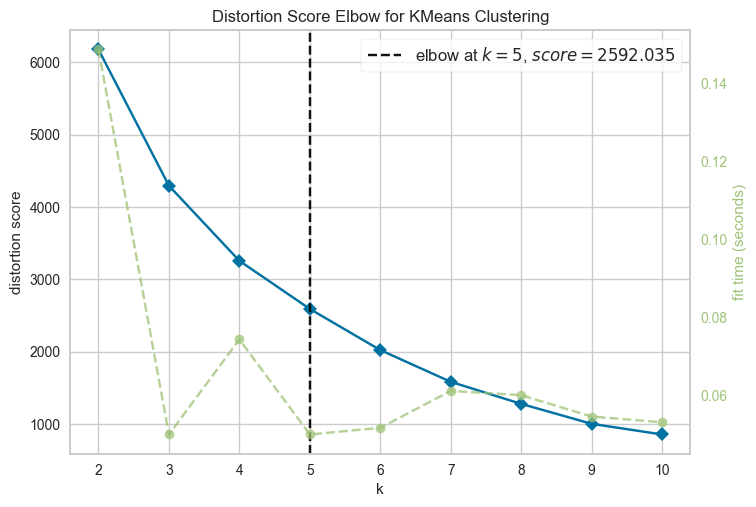

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), k=(2, 11))

In [23]:
# kelbow_visualizer
kelbow_visualizer(KMeans(), df_RFM, k=(2,11), timings=True, metric='distortion')

In [24]:
metrics = {
    'Method': [],
    'Sillhouete': [],
    'Davies Bouldin': [],
    'Calinski Harabasz': []
}

c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


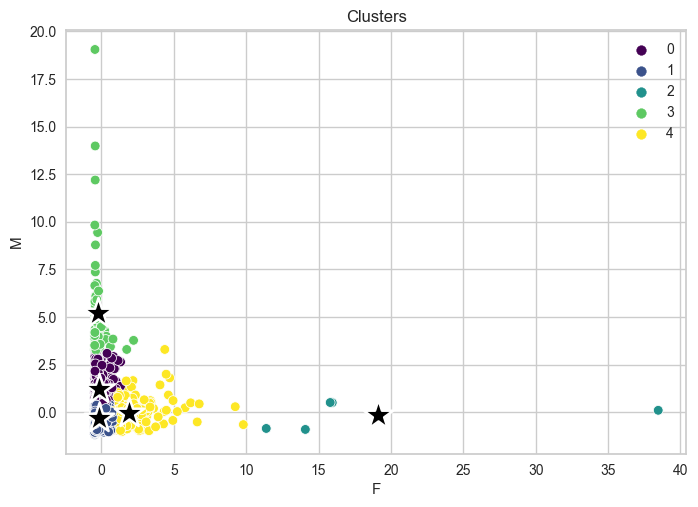

N por classe:  labels
1         3350
0          512
4          278
3           69
2            5
dtype: int64


{'Method': ['KMeans - 5 Clusters'],
 'Sillhouete': [0.5435266594106247],
 'Davies Bouldin': [0.6498621714728511],
 'Calinski Harabasz': [2383.83451152712]}

In [25]:
model_KMeans = KMeans(n_clusters=5)
model_KMeans.fit(df_RFM)
labels_KMeans = model_KMeans.labels_

ax = sns.scatterplot(data=df_RFM, x='F', y='M', hue=labels_KMeans, palette='viridis')
sns.scatterplot(x=model_KMeans.cluster_centers_[:,0], y=model_KMeans.cluster_centers_[:,1], marker='*', s=500, color='black', ax=ax)

plt.title('Clusters')
plt.show()

print('N por classe: ', pd.DataFrame({'labels': labels_KMeans}).value_counts())
metrics['Method'].append('KMeans - 5 Clusters')
metrics['Sillhouete'].append(silhouette_score(df_RFM, labels_KMeans))
metrics['Davies Bouldin'].append(davies_bouldin_score(df_RFM, labels_KMeans))
metrics['Calinski Harabasz'].append(calinski_harabasz_score(df_RFM, labels_KMeans))
metrics

Classes 1 and 2 got to little clients, let's try to reduce number of clusters

c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


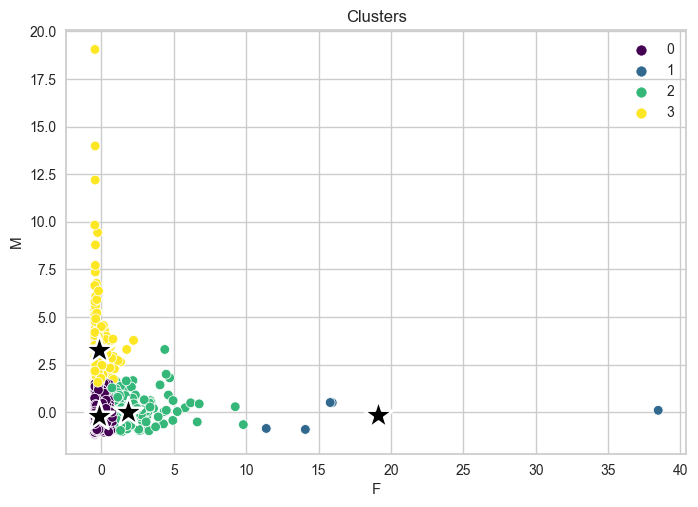

N por classe:  labels
0         3704
2          306
3          199
1            5
dtype: int64


{'Method': ['KMeans - 5 Clusters', 'KMeans - 4 Clusters'],
 'Sillhouete': [0.5435266594106247, 0.6159201072497729],
 'Davies Bouldin': [0.6498621714728511, 0.6552837513553881],
 'Calinski Harabasz': [2383.83451152712, 2239.608680834136]}

In [26]:
model_KMeans = KMeans(n_clusters=4)
model_KMeans.fit(df_RFM)
labels_KMeans = model_KMeans.labels_

ax = sns.scatterplot(data=df_RFM, x='F', y='M', hue=labels_KMeans, palette='viridis')
sns.scatterplot(x=model_KMeans.cluster_centers_[:,0], y=model_KMeans.cluster_centers_[:,1], marker='*', s=500, color='black', ax=ax)

plt.title('Clusters')
plt.show()

print('N por classe: ', pd.DataFrame({'labels': labels_KMeans}).value_counts())
metrics['Method'].append('KMeans - 4 Clusters')
metrics['Sillhouete'].append(silhouette_score(df_RFM, labels_KMeans))
metrics['Davies Bouldin'].append(davies_bouldin_score(df_RFM, labels_KMeans))
metrics['Calinski Harabasz'].append(calinski_harabasz_score(df_RFM, labels_KMeans))
metrics

c:\Users\carlo\.conda\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


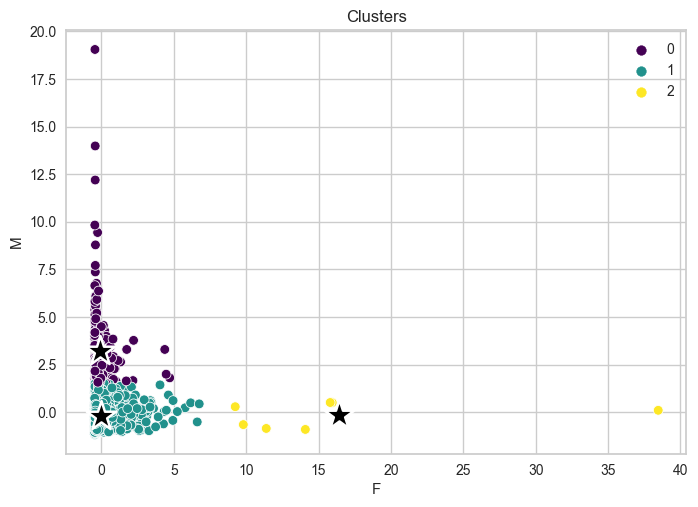

N por classe:  labels
1         3999
0          208
2            7
dtype: int64


{'Method': ['KMeans - 5 Clusters',
  'KMeans - 4 Clusters',
  'KMeans - 3 Clusters'],
 'Sillhouete': [0.5435266594106247, 0.6159201072497729, 0.7194238295515162],
 'Davies Bouldin': [0.6498621714728511,
  0.6552837513553881,
  0.5757455951979484],
 'Calinski Harabasz': [2383.83451152712,
  2239.608680834136,
  2025.8650835076683]}

In [27]:
model_KMeans = KMeans(n_clusters=3)
model_KMeans.fit(df_RFM)
labels_KMeans = model_KMeans.labels_

ax = sns.scatterplot(data=df_RFM, x='F', y='M', hue=labels_KMeans, palette='viridis')
sns.scatterplot(x=model_KMeans.cluster_centers_[:,0], y=model_KMeans.cluster_centers_[:,1], marker='*', s=500, color='black', ax=ax)

plt.title('Clusters')
plt.show()

print('N por classe: ', pd.DataFrame({'labels': labels_KMeans}).value_counts())
metrics['Method'].append('KMeans - 3 Clusters')
metrics['Sillhouete'].append(silhouette_score(df_RFM, labels_KMeans))
metrics['Davies Bouldin'].append(davies_bouldin_score(df_RFM, labels_KMeans))
metrics['Calinski Harabasz'].append(calinski_harabasz_score(df_RFM, labels_KMeans))
metrics

We keep having a cluster with only 7 clients, let's try another method

## Hierarquical Clustering - RFM

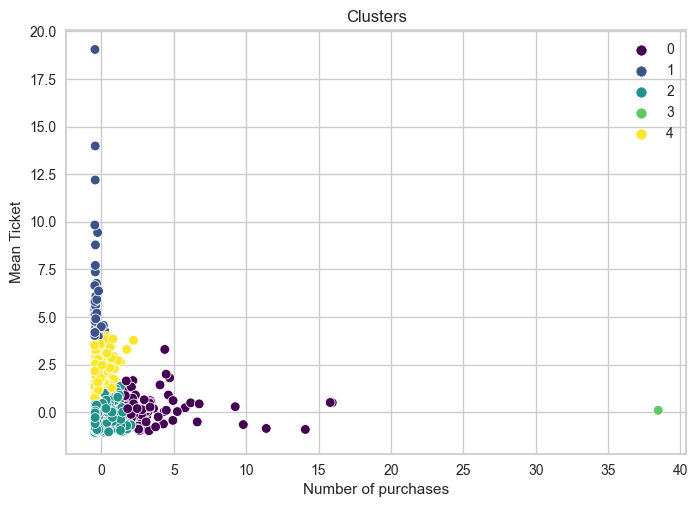

N por classe:  labels
2         3637
4          414
0          115
1           47
3            1
dtype: int64


{'Method': ['KMeans - 5 Clusters',
  'KMeans - 4 Clusters',
  'KMeans - 3 Clusters',
  'Hierarchical Clustering - 5 Clusters'],
 'Sillhouete': [0.5435266594106247,
  0.6159201072497729,
  0.7194238295515162,
  0.5682651544222957],
 'Davies Bouldin': [0.6498621714728511,
  0.6552837513553881,
  0.5757455951979484,
  0.5381808967660886],
 'Calinski Harabasz': [2383.83451152712,
  2239.608680834136,
  2025.8650835076683,
  2115.4260836789936]}

In [28]:
model_HCluster = AgglomerativeClustering(n_clusters=5)
labels_HCluster = model_HCluster.fit_predict(df_RFM)

ax = sns.scatterplot(data=df_RFM, x='F', y='M', hue=labels_HCluster, palette='viridis')

plt.title('Clusters')
plt.xlabel('Number of purchases')
plt.ylabel('Mean Ticket')

plt.show()

print('N por classe: ', pd.DataFrame({'labels': labels_HCluster}).value_counts())
metrics['Method'].append('Hierarchical Clustering - 5 Clusters')
metrics['Sillhouete'].append(silhouette_score(df_RFM, labels_HCluster))
metrics['Davies Bouldin'].append(davies_bouldin_score(df_RFM, labels_HCluster))
metrics['Calinski Harabasz'].append(calinski_harabasz_score(df_RFM, labels_HCluster))
metrics

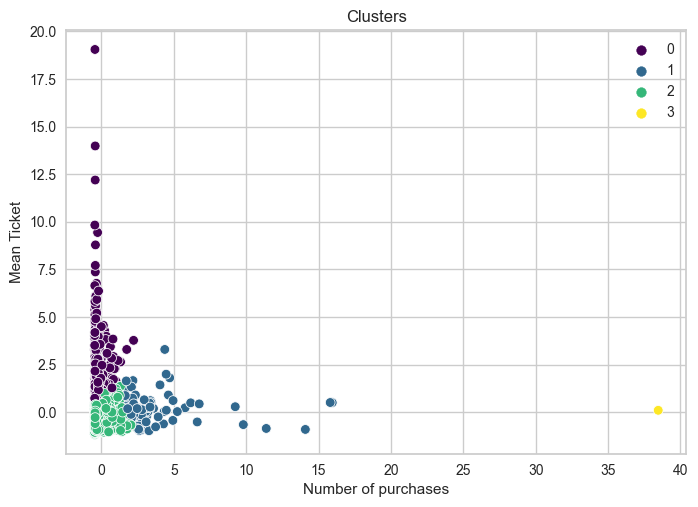

N por classe:  labels
2         3637
0          461
1          115
3            1
dtype: int64


{'Method': ['KMeans - 5 Clusters',
  'KMeans - 4 Clusters',
  'KMeans - 3 Clusters',
  'Hierarchical Clustering - 5 Clusters',
  'Hierarchical Clustering - 4 Clusters'],
 'Sillhouete': [0.5435266594106247,
  0.6159201072497729,
  0.7194238295515162,
  0.5682651544222957,
  0.6147623268489473],
 'Davies Bouldin': [0.6498621714728511,
  0.6552837513553881,
  0.5757455951979484,
  0.5381808967660886,
  0.5845348873134818],
 'Calinski Harabasz': [2383.83451152712,
  2239.608680834136,
  2025.8650835076683,
  2115.4260836789936,
  1842.1361273471714]}

In [29]:
model_HCluster = AgglomerativeClustering(n_clusters=4)
labels_HCluster = model_HCluster.fit_predict(df_RFM)

ax = sns.scatterplot(data=df_RFM, x='F', y='M', hue=labels_HCluster, palette='viridis')

plt.title('Clusters')
plt.xlabel('Number of purchases')
plt.ylabel('Mean Ticket')

plt.show()

print('N por classe: ', pd.DataFrame({'labels': labels_HCluster}).value_counts())
metrics['Method'].append('Hierarchical Clustering - 4 Clusters')
metrics['Sillhouete'].append(silhouette_score(df_RFM, labels_HCluster))
metrics['Davies Bouldin'].append(davies_bouldin_score(df_RFM, labels_HCluster))
metrics['Calinski Harabasz'].append(calinski_harabasz_score(df_RFM, labels_HCluster))
metrics

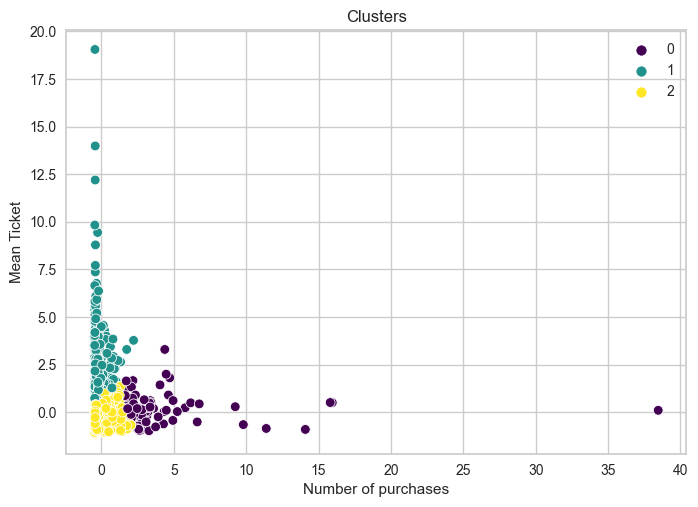

N por classe:  labels
2         3637
1          461
0          116
dtype: int64


{'Method': ['KMeans - 5 Clusters',
  'KMeans - 4 Clusters',
  'KMeans - 3 Clusters',
  'Hierarchical Clustering - 5 Clusters',
  'Hierarchical Clustering - 4 Clusters',
  'Hierarchical Clustering - 3 Clusters'],
 'Sillhouete': [0.5435266594106247,
  0.6159201072497729,
  0.7194238295515162,
  0.5682651544222957,
  0.6147623268489473,
  0.614794076456509],
 'Davies Bouldin': [0.6498621714728511,
  0.6552837513553881,
  0.5757455951979484,
  0.5381808967660886,
  0.5845348873134818,
  0.7852834004038303],
 'Calinski Harabasz': [2383.83451152712,
  2239.608680834136,
  2025.8650835076683,
  2115.4260836789936,
  1842.1361273471714,
  1536.3366746906358]}

In [30]:
model_HCluster = AgglomerativeClustering(n_clusters=3)
labels_HCluster = model_HCluster.fit_predict(df_RFM)

ax = sns.scatterplot(data=df_RFM, x='F', y='M', hue=labels_HCluster, palette='viridis')

plt.title('Clusters')
plt.xlabel('Number of purchases')
plt.ylabel('Mean Ticket')

plt.show()

print('N por classe: ', pd.DataFrame({'labels': labels_HCluster}).value_counts())
metrics['Method'].append('Hierarchical Clustering - 3 Clusters')
metrics['Sillhouete'].append(silhouette_score(df_RFM, labels_HCluster))
metrics['Davies Bouldin'].append(davies_bouldin_score(df_RFM, labels_HCluster))
metrics['Calinski Harabasz'].append(calinski_harabasz_score(df_RFM, labels_HCluster))
metrics

In [31]:
pd.DataFrame(metrics)

,Method,Sillhouete,Davies Bouldin,Calinski Harabasz
0,KMeans - 5 Clusters,0.543527,0.649862,2383.834512
1,KMeans - 4 Clusters,0.615920,0.655284,2239.608681
2,KMeans - 3 Clusters,0.719424,0.575746,2025.865084
3,Hierarchical Clustering - 5 Clusters,0.568265,0.538181,2115.426084
4,Hierarchical Clustering - 4 Clusters,0.614762,0.584535,1842.136127
5,Hierarchical Clustering - 3 Clusters,0.614794,0.785283,1536.336675


Considering metrics and size of clusters, we'll adopt Hierarchical Clustering - 3 Clusters, its metrics aren't so worse and it's the only one that has no cluster with less than 10 clients

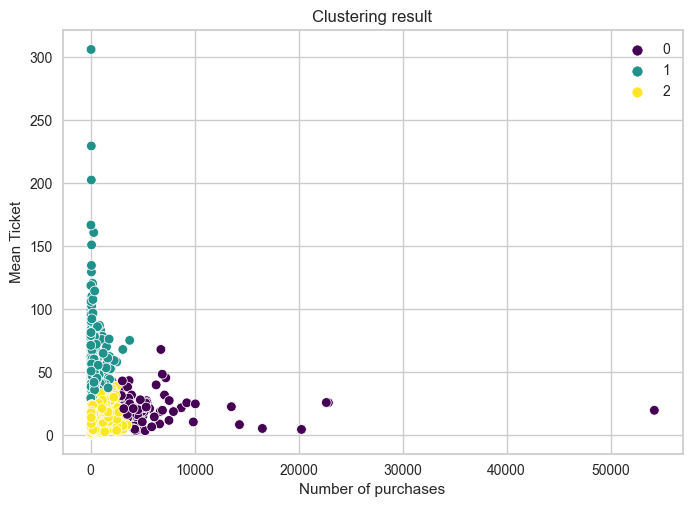

In [104]:
# exporting plot
df_RFM_original = df_RFM.copy()
df_RFM_original[['F', 'M']] = scaler.inverse_transform(df_RFM[['F', 'M']])       # reversing scaler transformation to express true values
ax = sns.scatterplot(data=df_RFM_original, x='F', y='M', hue=labels_HCluster, palette='viridis')

plt.title('Clustering result')
plt.xlabel('Number of purchases')
plt.ylabel('Mean Ticket')

plt.savefig('data/clusters.png')
plt.show()

In [33]:
df_RFM_labeled = df_RFM.copy()
df_RFM_labeled['Label'] = labels_HCluster
df_RFM_labeled

,F,M,Label
CustomerID,,,
12347.0,1.073882,0.214216,2
12348.0,-0.370571,-0.214881,2
12349.0,-0.026517,0.081017,2
12350.0,-0.330348,0.008033,2
12352.0,-0.103372,-0.060939,2
...,...,...,...
18280.0,-0.440244,-0.028016,2
18281.0,-0.433780,-0.588936,2
18282.0,-0.434498,-0.273948,2


In [34]:
# export data for application
df_RFM_labeled.to_csv('data/RFM_Labeled.csv')

## Recomendação

In [35]:
client = '17908.0'
cluster = df_RFM_labeled.loc[client]['Label']
cluster_clients = df_RFM_labeled.query('Label==2').index
recomendation = pd.DataFrame(sparse_itens_client.loc[cluster_clients].sum()).sort_values(by=0, ascending=False).nlargest(n=10, columns=0).index.to_list()
recomendation

['StockCode_85123A',
 'StockCode_84879',
 'StockCode_85099B',
 'StockCode_47566',
 'StockCode_22720',
 'StockCode_20725',
 'StockCode_21034',
 'StockCode_22469',
 'StockCode_22457',
 'StockCode_23203']

## Clusterização by purchase profile
Grouping clients based on the itens they bought

### COSINE SIMILARITY
Calculating similarity matrix on the sparse matrix calculated before

In [36]:
similarity_matrix = pd.DataFrame(cosine_similarity(sparse_itens_client))
similarity_matrix.index = sparse_itens_client.index.astype(str)
similarity_matrix.index.name = 'id'
similarity_matrix.columns = sparse_itens_client.index.astype(str)

similarity_matrix

CustomerID,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,12357.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
id,,,,,,,,,,,,,,,,,,,,,
12347.0,1.000000,0.059339,0.029819,0.024225,0.027347,0.0,0.041111,0.064600,0.055018,0.068980,...,0.0,0.000000,0.038847,0.000000,0.080750,0.145350,0.000000,0.085649,0.103027,0.000000
12348.0,0.059339,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.066227,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084220,0.000000
12349.0,0.029819,0.000000,1.000000,0.030773,0.104215,0.0,0.034816,0.000000,0.079872,0.140200,...,0.0,0.077850,0.000000,0.000000,0.041030,0.000000,0.000000,0.043519,0.062507,0.029013
12350.0,0.024225,0.000000,0.030773,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027771,0.000000
12352.0,0.027347,0.000000,0.104215,0.000000,1.000000,0.0,0.066519,0.000000,0.030521,0.044645,...,0.0,0.148741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022392,0.022173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.145350,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.063277,...,0.0,0.000000,0.000000,0.000000,0.111111,1.000000,0.149071,0.000000,0.000000,0.000000
18281.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.084895,...,0.0,0.000000,0.000000,0.000000,0.000000,0.149071,1.000000,0.000000,0.070968,0.000000
18282.0,0.085649,0.000000,0.043519,0.000000,0.000000,0.0,0.000000,0.117851,0.057354,0.000000,...,0.0,0.111803,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.005611,0.000000


In [37]:
# export to application
similarity_matrix.to_csv('data/similarity_matrix.csv')

In [38]:
# Clustering in k equal sized clusters
k = 4                           # n clusters
n = len(similarity_matrix)      # n of clients
nk = int(np.round(n/k,0))       # size of each cluster
clients = np.full((n,2), '', dtype='<U7')

for i in range(k):
    max_similarity = pd.DataFrame(similarity_matrix.sum()).sort_values(by=0, ascending=False)
    client = max_similarity.index[0]            # client with biggest summed similarity value, we may look at it as the centroid

    if i < k-1:
        clients[i*nk : i*nk+nk,0] = pd.DataFrame(similarity_matrix[client].nlargest(nk)).index.to_list()   # colecting most similar clients
        clients[i*nk : i*nk+nk,1] = i

        similarity_matrix.drop(clients[i*nk : i*nk+nk,0], inplace=True)                 # removing selected clients from similarity matrix
        similarity_matrix.drop(columns=clients[i*nk : i*nk+nk,0], inplace=True)

    else:
        clients[i*nk : ,0] = similarity_matrix.index.to_list()
        clients[i*nk : ,1] = i
    
    

clients = pd.DataFrame(clients, columns=['CustomerID', 'Label'])


In [39]:
clients

,CustomerID,Label
0,14911.0,0
1,14156.0,0
2,12748.0,0
3,14769.0,0
4,14895.0,0
...,...,...
4209,18273.0,3
4210,18274.0,3
4211,18278.0,3
4212,18280.0,3


In [40]:
clients['CustomerID'].value_counts().sort_values(ascending=False)       # no duplicated client

14911.0    1
13317.0    1
18118.0    1
12748.0    1
14769.0    1
          ..
18255.0    1
18269.0    1
18273.0    1
18274.0    1
18282.0    1
Name: CustomerID, Length: 4214, dtype: int64

In [41]:
clients['Label'].value_counts()         # equal sized clusters

0    1054
1    1054
2    1054
3    1052
Name: Label, dtype: int64

### Recomendação

In [42]:
similarity_matrix = pd.DataFrame(cosine_similarity(sparse_itens_client))
similarity_matrix.index = sparse_itens_client.index.astype(str)
similarity_matrix.index.name = 'id'
similarity_matrix.columns = sparse_itens_client.index.astype(str)

In [43]:
client = '17908.0'

In [44]:
similar_clients = pd.DataFrame(similarity_matrix[client]).sort_values(by=client, ascending=False).reset_index().nlargest(n=11, columns=client)['id'].to_list()[1:]

In [45]:
most_bought_itens = pd.DataFrame(sparse_itens_client.loc[similar_clients].sum()).sort_values(by=0, ascending=False).nlargest(n=10, columns=0).index.to_list()
most_bought_itens           # recomendation

['StockCode_85099B',
 'StockCode_21931',
 'StockCode_85099F',
 'StockCode_22386',
 'StockCode_21928',
 'StockCode_23203',
 'StockCode_20724',
 'StockCode_20723',
 'StockCode_85123A',
 'StockCode_85099C']

# Insights comerciais

In [93]:
df_RFM_original['Label'] = labels_HCluster
df_RFM_original['TotalSpent'] = df_RFM_original['F'] * df_RFM_original['M']
df_RFM_original

,F,M,Label,TotalSpent
CustomerID,,,,
12347.0,2151.0,21.513966,2,46276.539828
12348.0,140.0,15.033333,2,2104.666667
12349.0,619.0,19.502273,2,12071.906818
12350.0,196.0,18.400000,2,3606.400000
12352.0,512.0,17.358310,2,8887.454648
...,...,...,...,...
18280.0,43.0,17.855556,2,767.788889
18281.0,52.0,9.384000,2,487.968000
18282.0,51.0,14.141250,2,721.203750


In [101]:
cluster_analisys = df_RFM_original.groupby('Label')['TotalSpent'].agg(['count', 'mean', 'min', 'median', 'max', 'sum']).reset_index().set_index('Label')
cluster_analisys

,count,mean,min,median,max,sum
Label,,,,,,
0,116,116041.223041,16541.218921,82288.913295,1.078991e+06,1.346078e+07
1,461,16059.244907,136.000000,7530.971429,2.826461e+05,7.403312e+06
2,3637,8241.294064,2.900000,3920.980000,9.704545e+04,2.997359e+07


In [102]:
cluster_analisys.to_csv('data/cluster_analisys.csv')

This analisys shows that the most profitable cluster is the one labeled 0 (High Frequency and smaller Mean Ticket), followed by clusters 1 and 2. In fact, cluster 0 clients spent 7 times more in average than cluster 1 and 14 times more than cluster 2 clients.

Therefore, the company can increase its earnings by increasing frequency of purchases, so it would be interest for the company to set strategies to retain customers, even if it requires to reduce prices.

Another strategy is to implement a recomendation system so the company's website, as described before.